# Hand Gestures Classification

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

## Data Loading

In [3]:
df = pd.read_csv(r'Data/hand_landmarks_data.csv')
df.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,x19,y19,z19,x20,y20,z20,x21,y21,z21,label
0,262.669968,257.304901,-3.649205e-07,257.417542,247.109055,0.004224,246.882957,241.716827,0.005798,236.384537,...,223.345093,255.490692,-0.020450,215.043365,258.114746,-0.024577,208.006393,259.608673,-0.026722,call
1,83.351778,346.059113,-2.345265e-07,81.925037,328.562347,-0.011102,90.080132,311.535248,-0.021096,95.641823,...,132.451618,341.794434,-0.038175,142.773582,342.829254,-0.037336,152.431698,343.015991,-0.036136,call
2,187.756977,260.235492,-2.417307e-07,195.460579,241.506035,-0.000184,207.259529,223.674339,-0.009687,215.413628,...,250.301010,268.602938,-0.044068,262.425133,271.276638,-0.040469,272.989952,272.272231,-0.038301,call
3,114.976696,331.594238,-1.233261e-07,114.503494,320.549957,-0.002824,116.636627,310.080994,-0.008911,117.685066,...,145.195450,329.357544,-0.027622,151.053200,329.712341,-0.027863,155.990364,329.548828,-0.027723,call
4,188.795288,141.727867,-1.622995e-07,188.520905,127.947464,-0.002884,191.982880,111.010563,-0.008115,192.552521,...,226.696396,132.263248,-0.025113,234.831741,130.684147,-0.024087,241.587769,128.477188,-0.023486,call


## Data Visualization

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25675 entries, 0 to 25674
Data columns (total 64 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      25675 non-null  float64
 1   y1      25675 non-null  float64
 2   z1      25675 non-null  float64
 3   x2      25675 non-null  float64
 4   y2      25675 non-null  float64
 5   z2      25675 non-null  float64
 6   x3      25675 non-null  float64
 7   y3      25675 non-null  float64
 8   z3      25675 non-null  float64
 9   x4      25675 non-null  float64
 10  y4      25675 non-null  float64
 11  z4      25675 non-null  float64
 12  x5      25675 non-null  float64
 13  y5      25675 non-null  float64
 14  z5      25675 non-null  float64
 15  x6      25675 non-null  float64
 16  y6      25675 non-null  float64
 17  z6      25675 non-null  float64
 18  x7      25675 non-null  float64
 19  y7      25675 non-null  float64
 20  z7      25675 non-null  float64
 21  x8      25675 non-null  float64
 22

#### How many instances of every label are there in the data?

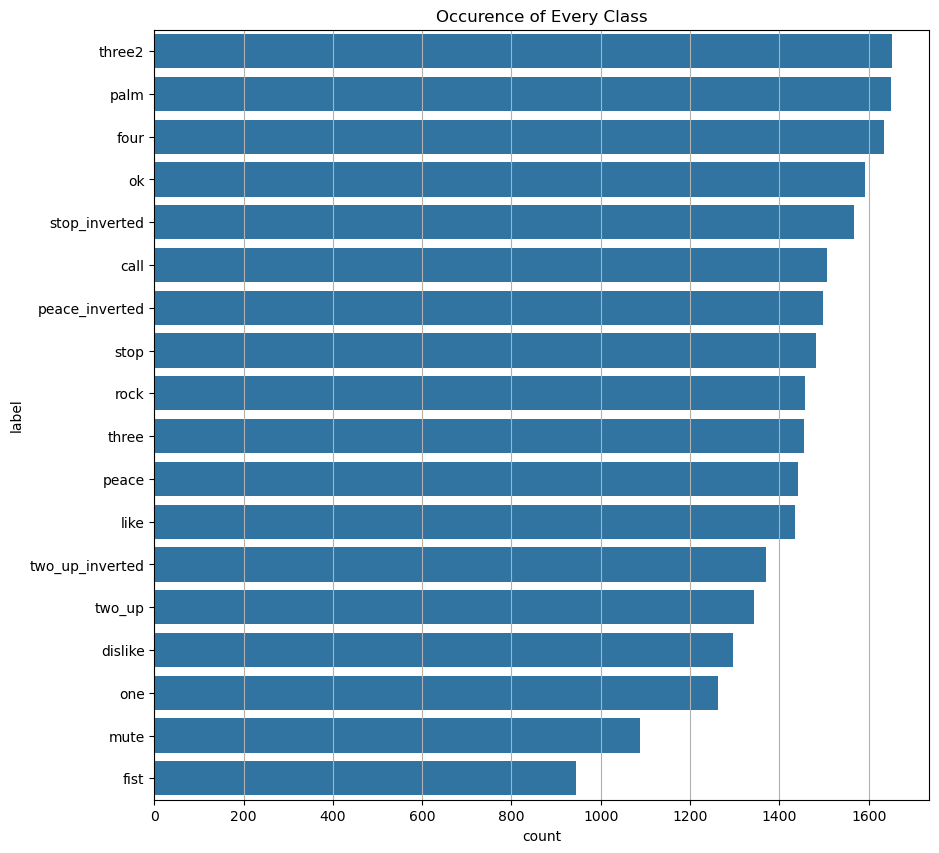

In [5]:
plt.figure(figsize=(10,10))
labels_sorted = df.label.value_counts()
sns.barplot(labels_sorted, orient='h')
plt.grid(axis = 'x')
plt.title("Occurence of Every Class")
plt.show()


#### What is the distribution of each column?

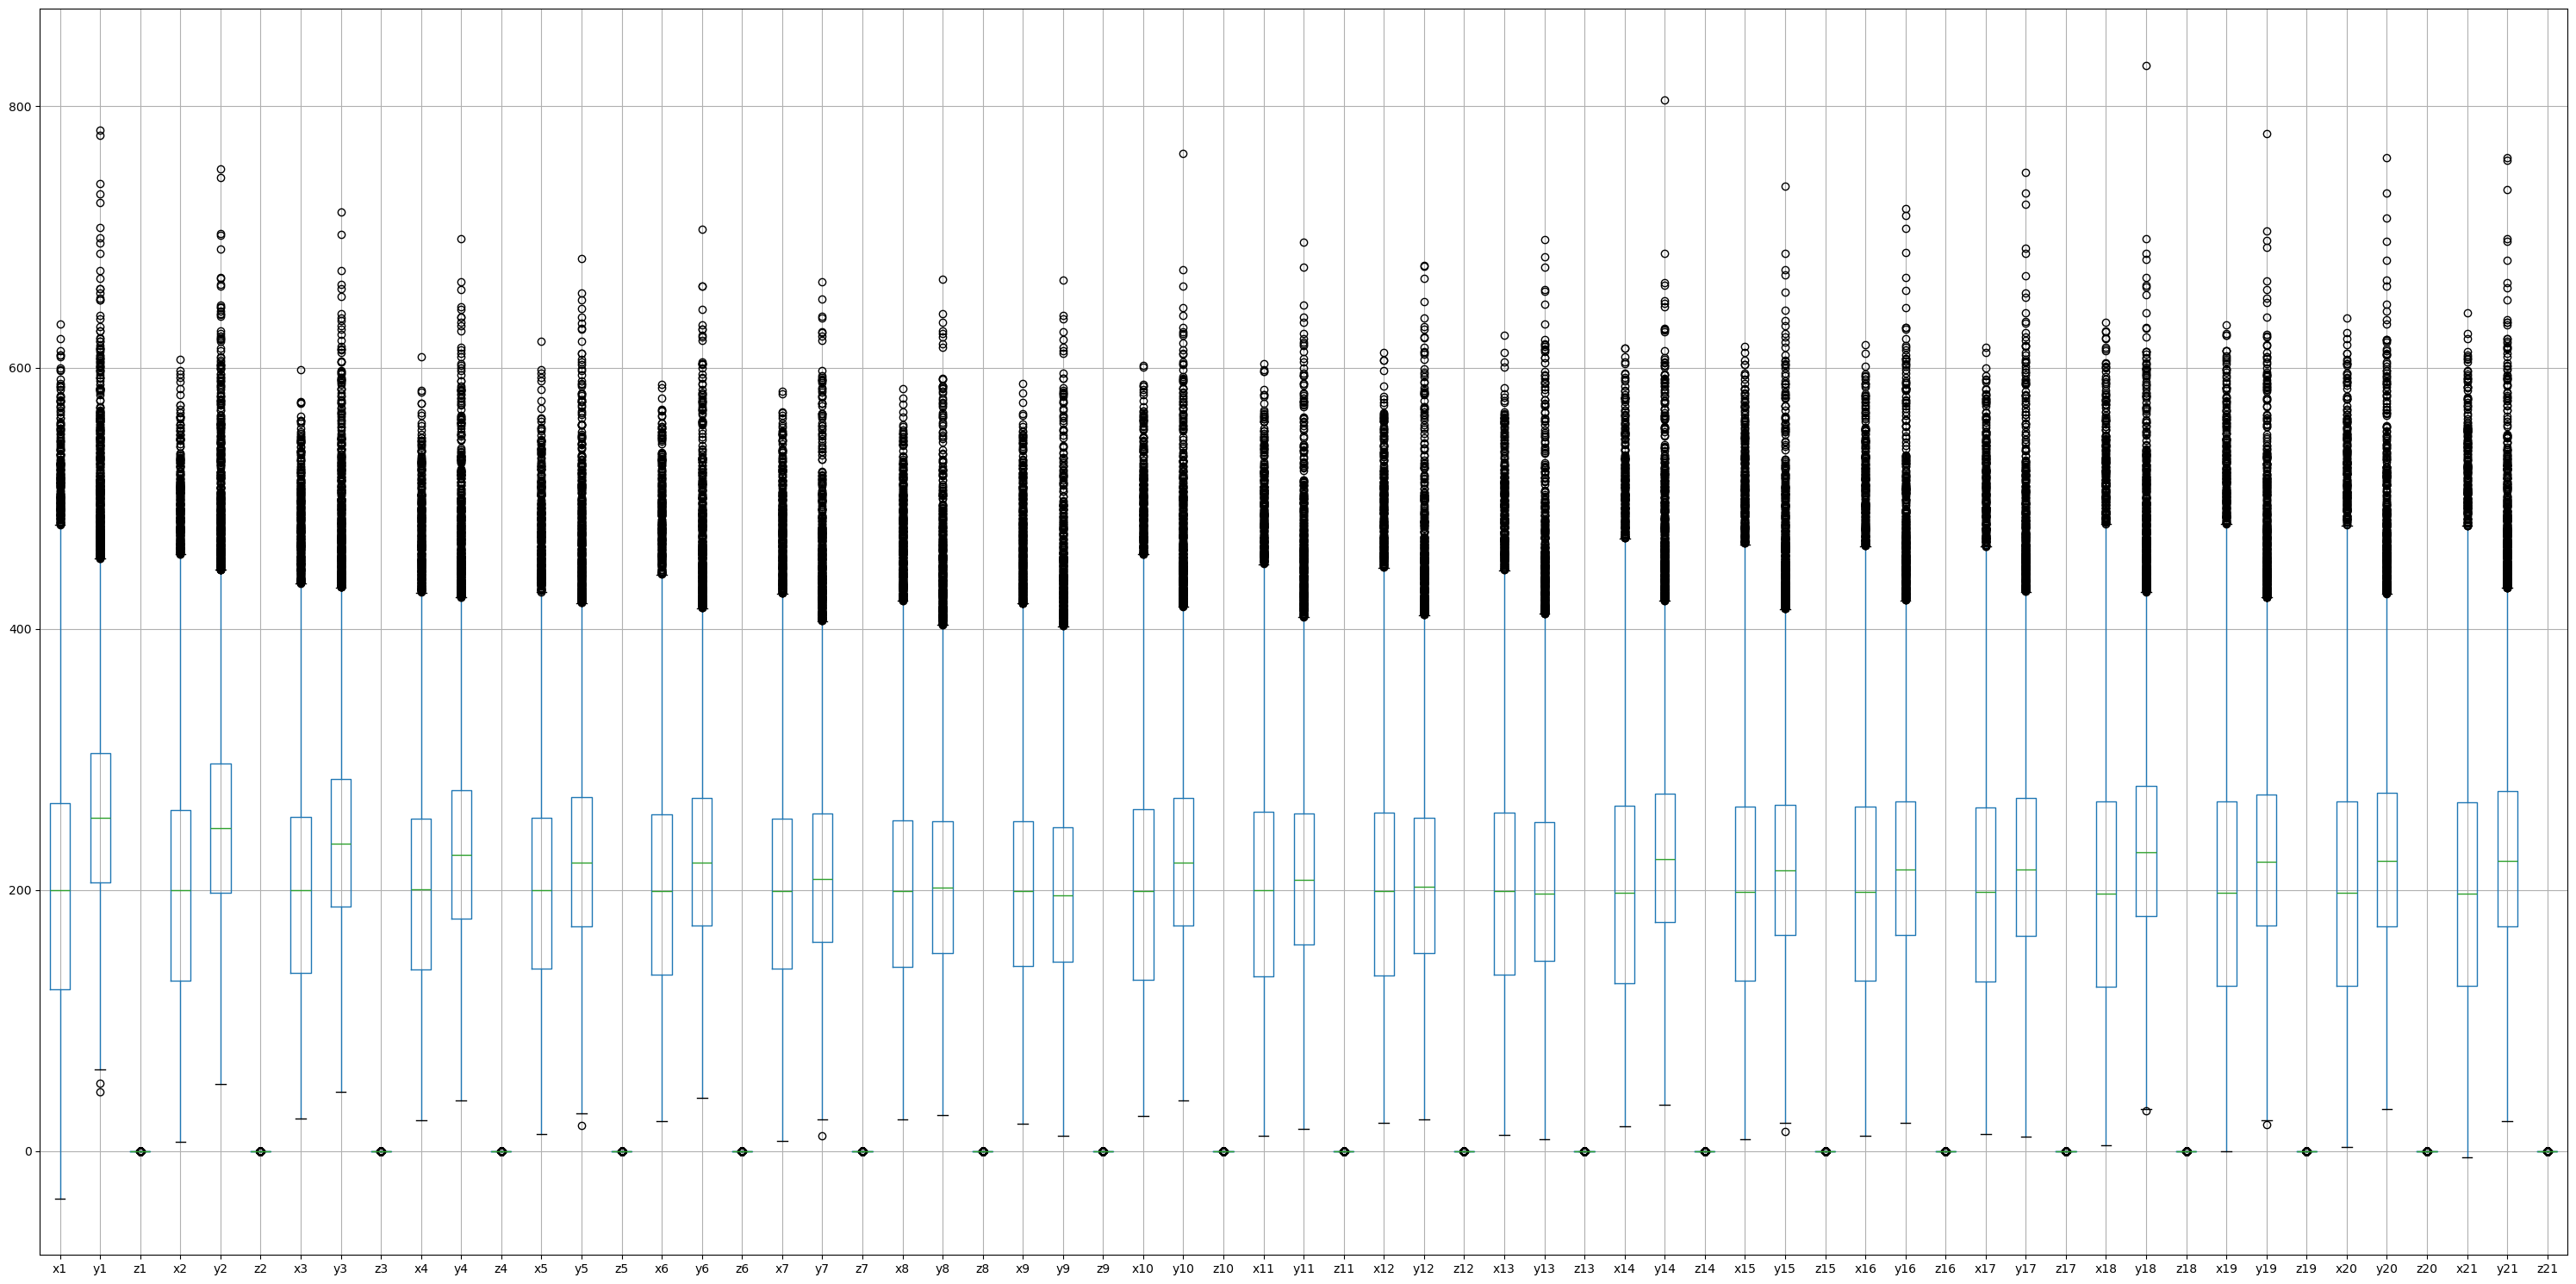

In [6]:
df.boxplot(figsize=(30,15))
plt.tight_layout()
plt.show()

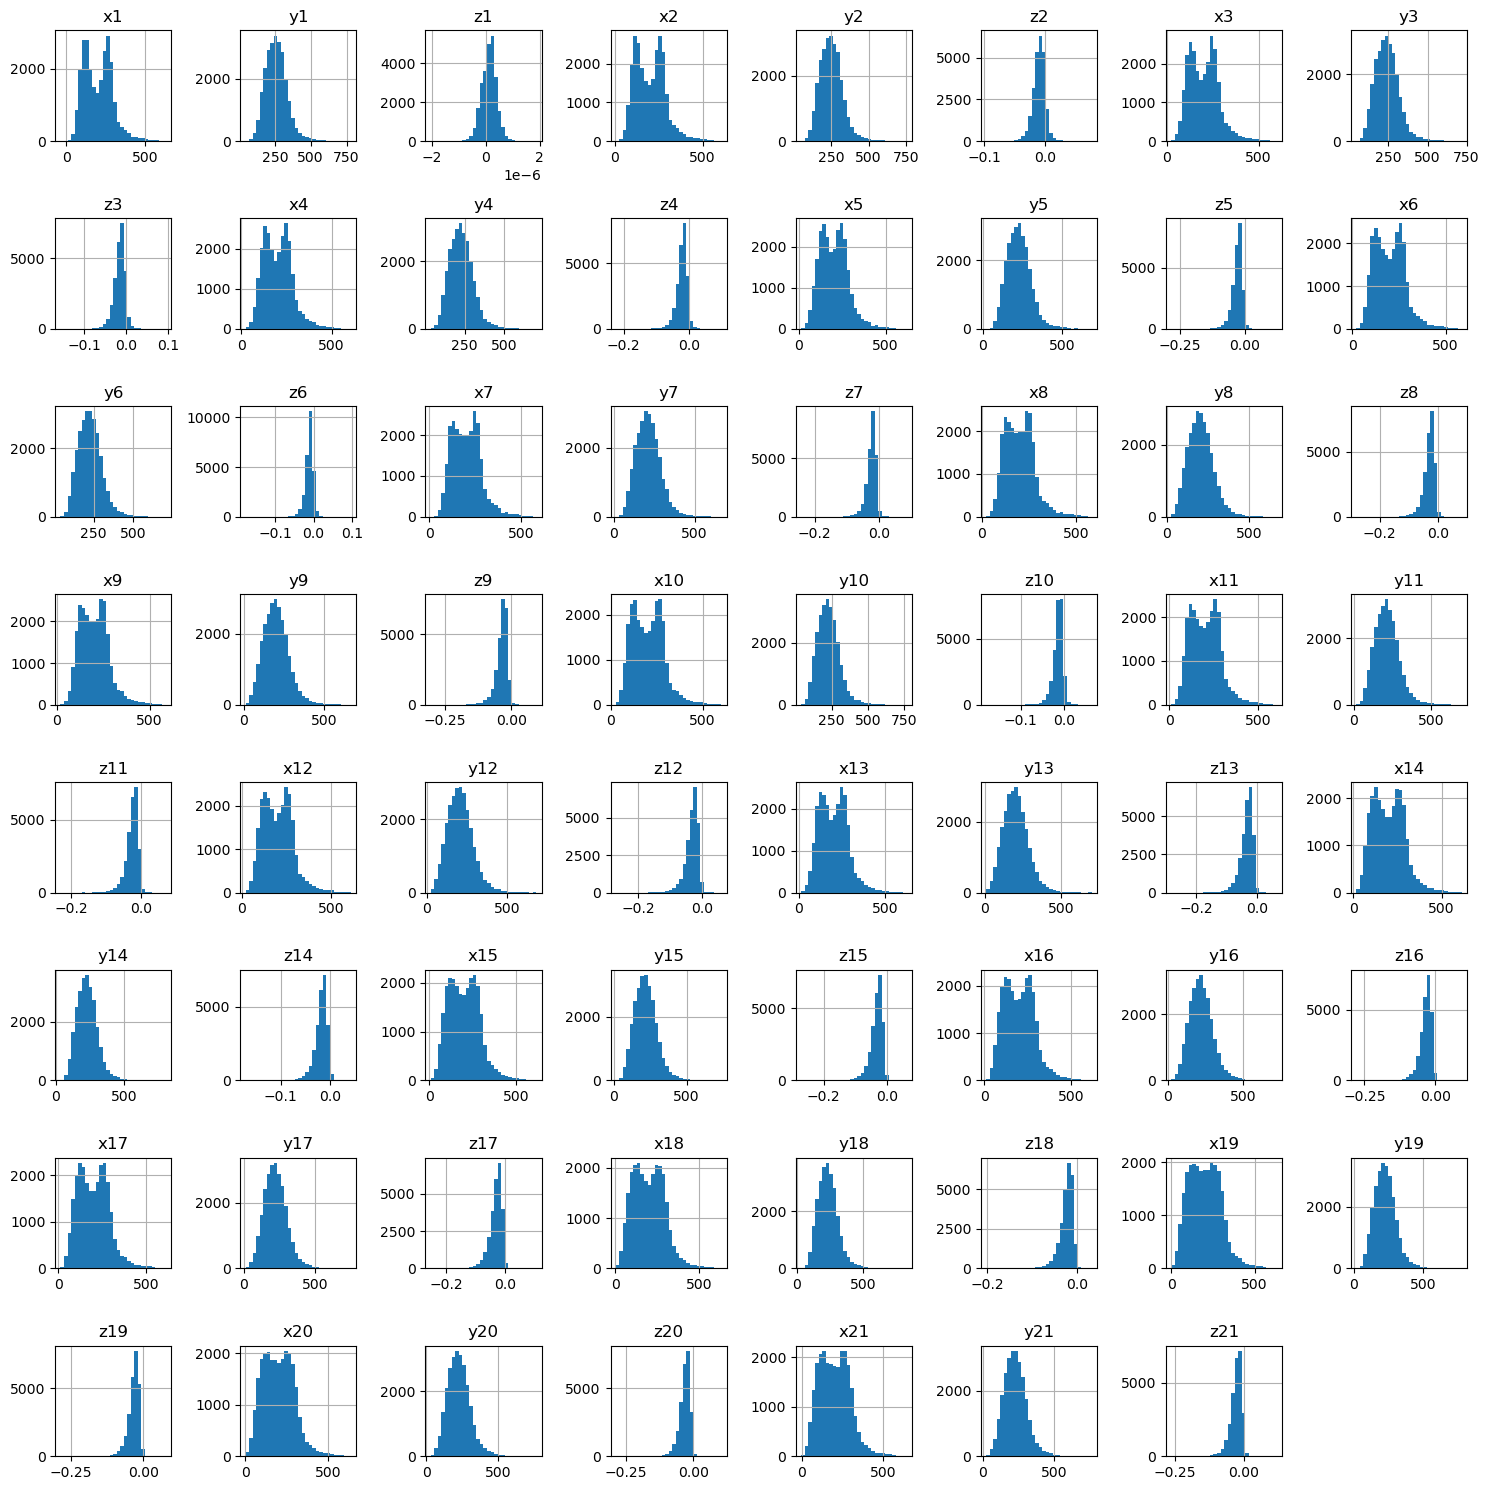

In [7]:
df.hist(figsize=(15,15), bins=30)
plt.tight_layout()
plt.show()

We can notice that most of the data follows the same shape but the X, Y variables have very big scale compared with the Z variables. We will deal with this later.

In [8]:
dic = {}
for label in df.label.unique():
    dic[label] = {
        'x': df[df['label'] == label].iloc[0][:-1:3].values,
        'y': df[df['label'] == label].iloc[0][1:-1:3].values,
        'z': df[df['label'] == label].iloc[0][2:-1:3].values
    }


In [9]:

for key, value in dic.items():    
    fig = px.scatter_3d(**value, title=key)
    fig.show()
    


## Data Preprocessing

Q: Are there any missing values?

In [10]:
df.columns[df.isnull().sum()>0]

Index([], dtype='object')

From the histogram above we see that there is difference in scaling between variables:
* X, Y variables values range between 0 and 500.
* Z variable value range from -1 to 1

So We need to normalize the values of X and Y.

But first lets recenter the hand landmarks to make the origin the **wrist point (x1, y1)** by subtracting all the points by it. Then dividing all landmarks by the **mid-finger tip point (x13, y13)**.


In [11]:
df.shape[0]

25675

In [12]:
def GetCenteredRow(x: pd.Series) -> pd.Series:
    """takes a row and returns a modified row centerd with $x_i = (x_i-x_0)/x_12$ 
    and $y_i = (y_i-y_0)/y_12$

    Arguments:
        x -- row as a pd.series with data of 21 point + label

    Returns:
        modified row centered 
    """
    xs = (x[0:-1:3] - x.iloc[0])/x.iloc[12]
    ys = (x[1:-1:3] - x.iloc[1])/x.iloc[13]
    zs =  x[2:-1:3]
    label = x[-1:-2:-1]
    
    return pd.concat([xs, ys, zs, label])
    
    

In [13]:
centered_df = df.apply(GetCenteredRow, axis=1)
centered_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,z13,z14,z15,z16,z17,z18,z19,z20,z21,label
0,0.0,-0.022829,-0.068616,-0.114246,-0.141663,-0.106659,-0.160891,-0.159134,-0.149994,-0.112082,...,-0.016854,-0.009528,-0.016194,-0.020701,-0.023142,-0.013198,-0.020450,-0.024577,-0.026722,call
1,0.0,-0.015103,0.071222,0.130094,0.117694,0.264611,0.458044,0.392556,0.319301,0.310253,...,-0.036610,-0.026222,-0.034942,-0.030081,-0.027561,-0.029042,-0.038175,-0.037336,-0.036136,call
2,0.0,0.035869,0.090805,0.128772,0.125788,0.183436,0.268346,0.240473,0.206110,0.194741,...,-0.027500,-0.033584,-0.038898,-0.033344,-0.030234,-0.041256,-0.044068,-0.040469,-0.038301,call
3,0.0,-0.004053,0.014216,0.023195,0.015329,0.126751,0.211183,0.183449,0.144711,0.154037,...,-0.021387,-0.017837,-0.021707,-0.018406,-0.017291,-0.021804,-0.027622,-0.027863,-0.027723,call
4,0.0,-0.001458,0.016934,0.019960,-0.002952,0.074544,0.162533,0.143107,0.113868,0.093203,...,-0.023731,-0.018826,-0.023907,-0.020978,-0.019323,-0.021623,-0.025113,-0.024087,-0.023486,call


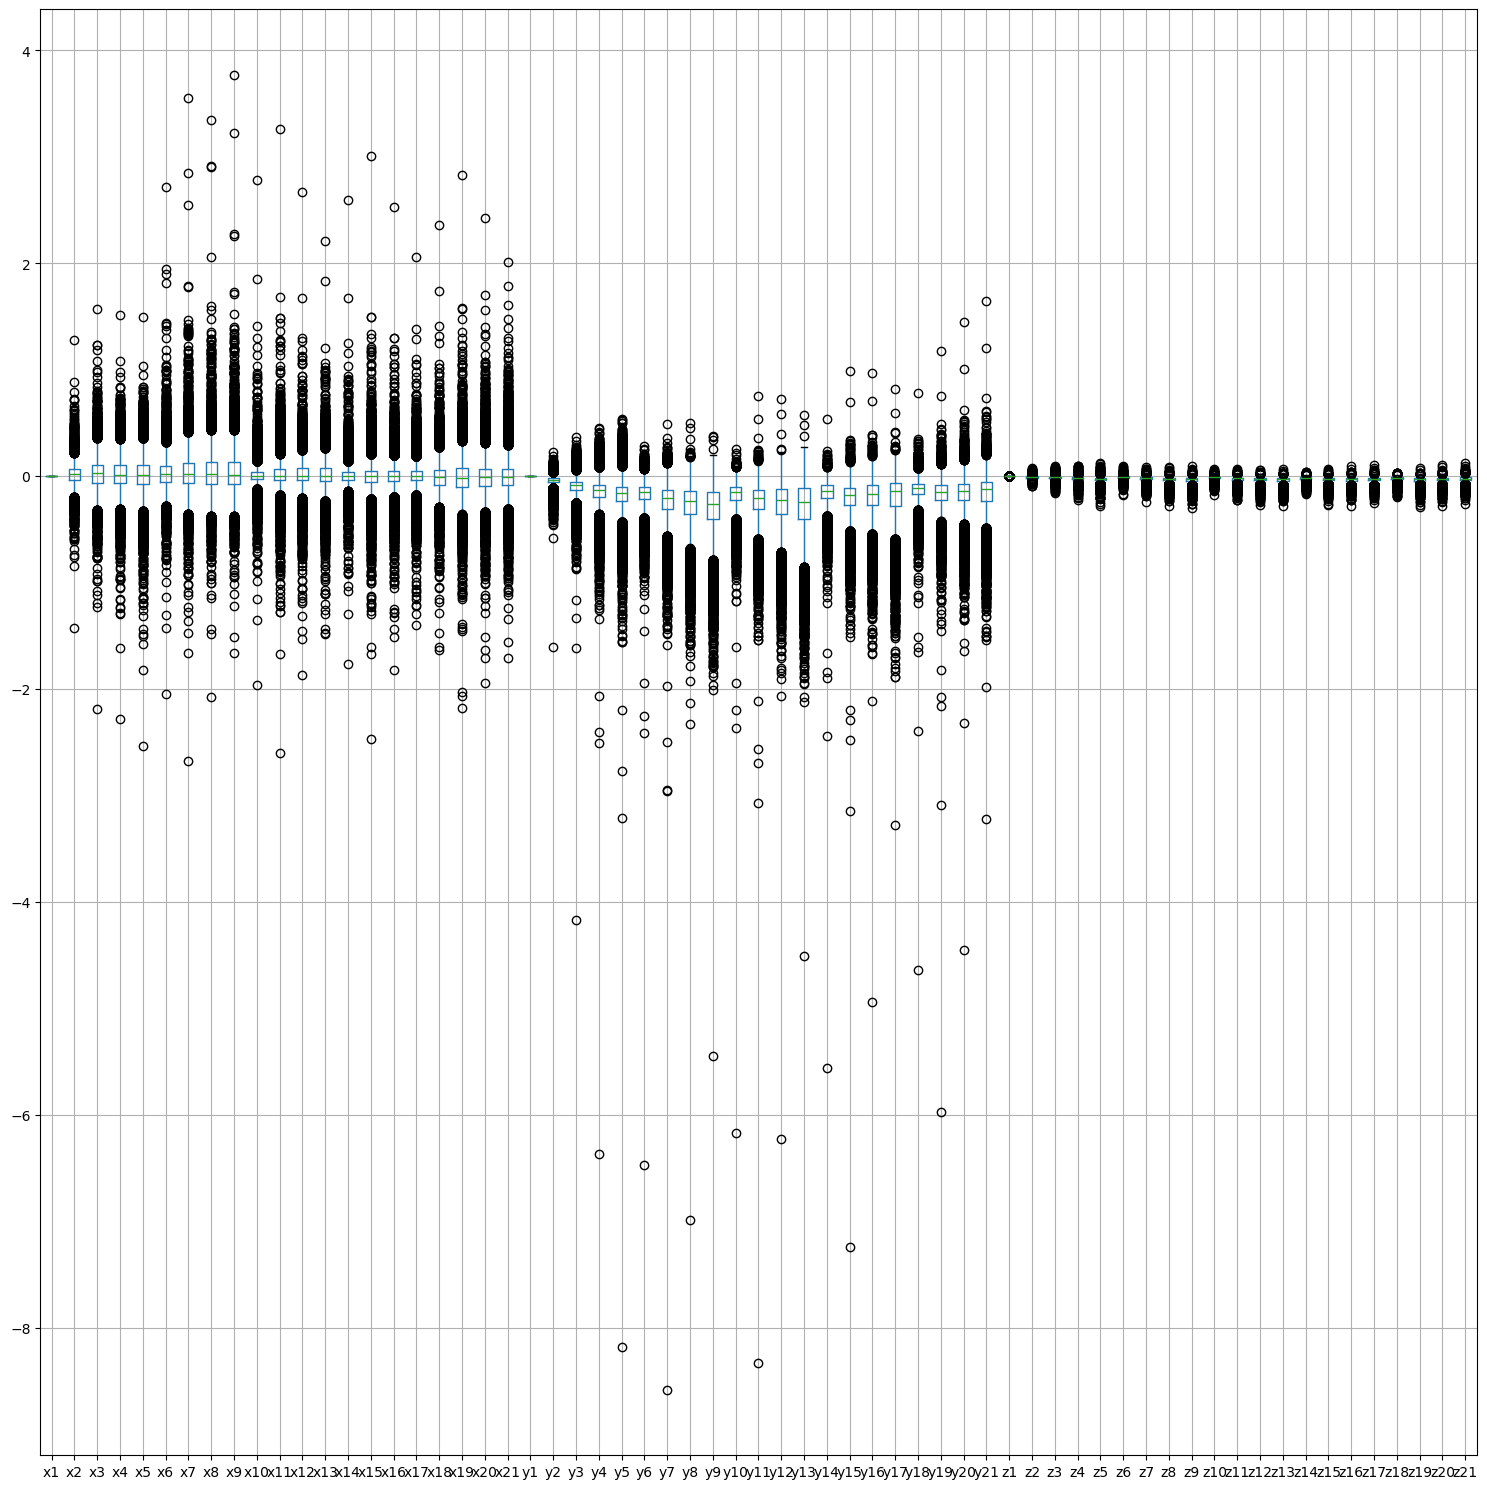

In [14]:
centered_df.boxplot(figsize=(15,15))
plt.tight_layout()
plt.show()

In [19]:
df_train = centered_df.drop('label', axis = 1)
df_test = centered_df['label']

Xtrain, Xtest, ytrain, ytest = train_test_split(df_train, df_test, test_size=0.3, shuffle=True, random_state=0)
Xvalid, Xtest, yvalid, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=0)

## Model Training

### Decision Trees

In [33]:
rforest = RandomForestClassifier(random_state=0, n_estimators=200, max_depth= 50)
rforest.fit(Xtrain, ytrain)


RandomForestClassifier(max_depth=50, n_estimators=200, random_state=0)

In [34]:
print(rforest.score(Xtrain, ytrain))
print(rforest.score(Xvalid, yvalid))

1.0
0.9353414697481174


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Import classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

RANDOM_STATE = 42

X_train, X_val, y_train, y_val = Xtrain, Xvalid, ytrain, yvalid
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)  

models = {
    'SVC': {
        'model': SVC(decision_function_shape='ovr', probability=True, random_state=RANDOM_STATE),
        'params': {
            'model__C': [20.0, 25.0],
            'model__kernel': ['rbf']
        }
    },
    'RandomForestClassifier': {
        'model': RandomForestClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 200, 300],
            'model__max_depth': [None, 30],
            'model__min_samples_split': [5]
        }
    },
    'XGBClassifier': {  
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 300, 500],
            'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
            'model__max_depth': [3, 5, 7],
            'model__subsample': [0.6, 0.8, 1.0],
            'model__colsample_bytree': [0.6, 0.8, 1.0],
            'model__gamma': [0, 0.1, 0.2],
            'model__reg_lambda': [0, 1, 5, 10]
        }
    },
}

results = []

best_models = {}

for name, mp in models.items():
    print(f"Training {name}...")
    pipeline = Pipeline([('model', mp['model'])])
    
    grid = GridSearchCV(pipeline, mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_  # Store best model
    
    train_pred = grid.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    
    val_pred = grid.predict(X_val)
    val_acc = accuracy_score(y_val, val_pred)
    
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc
    })
    
    print(f"Best Params: {grid.best_params_}")
    print(f"Train Accuracy: {train_acc:.4f} | Validation Accuracy: {val_acc:.4f}\n")

# Display all results
results_df = pd.DataFrame(results)
print("Summary of Model Performances:")
print(results_df.sort_values(by='Validation Accuracy', ascending=False))

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best model name
best_model_name = results_df.loc[results_df['Validation Accuracy'].idxmax(), 'Model']

# Retrieve the best model
best_model = best_models[best_model_name]

print(f"\n🚀 Best Model: {best_model_name} with Validation Accuracy: {results_df['Validation Accuracy'].max():.4f}")


Training LogisticRegression...
Best Params: {'model__C': 10.0, 'model__penalty': 'l1'}
Train Accuracy: 0.8738 | Validation Accuracy: 0.8574

Training SVC...
Best Params: {'model__C': 20.0, 'model__kernel': 'rbf'}
Train Accuracy: 0.9786 | Validation Accuracy: 0.9686

Training RandomForestClassifier...
Best Params: {'model__max_depth': 30, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Train Accuracy: 0.9997 | Validation Accuracy: 0.9320

Training GradientBoostingClassifier...
Best Params: {'model__learning_rate': 0.15, 'model__max_depth': 5, 'model__n_estimators': 300}
Train Accuracy: 1.0000 | Validation Accuracy: 0.9722

Training AdaBoostClassifier...
Best Params: {'model__learning_rate': 1.0, 'model__n_estimators': 300}
Train Accuracy: 0.5748 | Validation Accuracy: 0.5606

Training ExtraTreesClassifier...


/home/amado/anaconda3/envs/hand_gest/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Best Params: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 300}
Train Accuracy: 1.0000 | Validation Accuracy: 0.9291

Summary of Model Performances:
                        Model  \
3  GradientBoostingClassifier   
1                         SVC   
2      RandomForestClassifier   
5        ExtraTreesClassifier   
0          LogisticRegression   
4          AdaBoostClassifier   

                                         Best Params  Train Accuracy  \
3  {'model__learning_rate': 0.15, 'model__max_dep...        1.000000   
1         {'model__C': 20.0, 'model__kernel': 'rbf'}        0.978633   
2  {'model__max_depth': 30, 'model__min_samples_s...        0.999666   
5  {'model__max_depth': None, 'model__min_samples...        1.000000   
0         {'model__C': 10.0, 'model__penalty': 'l1'}        0.873804   
4  {'model__learning_rate': 1.0, 'model__n_estima...        0.574783   

   Validation Accuracy  
3             0.972215  
1             0.968580  
2   

In [ ]:
!pip install xgboost


  Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached nvidia_nccl_cu12-2.26.2-py3-none-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-3.0.0-py3-none-manylinux_2_28_x86_64.whl (253.9 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/201.3 MB 256.1 kB/s eta 0:12:59

## Evaluation

## Conclusion